In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import gaussian_kde
import time
from sklearn.inspection import permutation_importance

# Machine learning libraries
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.neural_network import MLPRegressor

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Read data
prop = "stellar_mass"          # the property to predict
r = 42                  # random_state to use everywhere, None for random results

dat_train = pd.read_csv("Data/IllustrisTNG300-1-train.csv", header=0)
dat_test = pd.read_csv("Data/IllustrisTNG300-1-val.csv", header=0)

print(dat_train.shape)
print(dat_test.shape)

(123300, 16)
(41100, 16)


In [3]:
features = ["M200c", "sigma", "c200c", "z_form", "M_acc", "E_s", "f_mass_cen", "R0p9", "spin"]    # list of features

plot_densities = True   # whether or not to plot point densities 
sample_size = 10000     # if plotting densities, plot a smaller sample since calculating densities takes a long time
if sample_size < 1:
    sample_size = int(sample_size*dat_test.shape[0])

save_figs = False        # whether to save the figures as png files
quantiles = [5, 95]

# Get x and y
x_train = dat_train[features]
y_train = dat_train[[prop]]
print(x_train.head())

x_test = dat_test[features]
y_test = dat_test[[prop]]

# standardize the data
x_test = (x_test-x_train.mean())/x_train.std()
x_train = (x_train-x_train.mean())/x_train.std()

y_test = y_test.to_numpy().reshape(-1,)
y_train = y_train.to_numpy().reshape(-1,)

print(x_test.shape, y_test.shape)

       M200c      sigma     c200c    z_form     M_acc        E_s  f_mass_cen  \
0  11.423144  67.867319  0.883694  1.078324  0.658514  14.751925    0.911639   
1  11.165382  57.869746  0.879829  1.254843 -0.495043  14.370393    0.954870   
2  11.588563  79.070478  0.865964  0.958822  0.246556  15.062748    0.980968   
3  11.600356  80.696796  0.872129  1.446222  0.846326  15.116039    0.967982   
4  10.964773  48.684645  0.985367  1.511623  0.229156  13.926382    0.982056   

         R0p9      spin  
0  130.850432  0.014209  
1  107.874705  0.022668  
2  148.124643  0.077505  
3  149.866912  0.062712  
4   87.822598  0.066108  
(41100, 9) (41100,)


In [6]:

hyperparam = [10, 25, 50, 75, 100] # !
hpname = "n_estimators" # !

R2scores = []
MSEs = []
correlations = []
times = []

measures = ["R2 score", "MSE", "correlation", "time (s)"]

for n in hyperparam:
    start = time.time()

    # choose model
    model = RandomForestRegressor(n_estimators=n, min_samples_leaf=10)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    t = time.time() - start
    times.append(t)

    R2scores.append(r2_score(y_test, y_pred))
    MSEs.append(mean_squared_error(y_test, y_pred))
    correlations.append(np.corrcoef(y_test, y_pred)[0,1])

print(R2scores)
print(MSEs)
print(correlations)
print(times)

measurelist = [R2scores, MSEs, correlations, times]


[0.9458880986016155, 0.9472381516910289, 0.9475715207861954, 0.947613178393089, 0.947738510262444]
[0.024444077408765513, 0.023834215227420165, 0.02368362173953015, 0.023664803665478917, 0.023608187249549512]
[0.9725704942905632, 0.9732631360180687, 0.9734344157331308, 0.9734561663141086, 0.9735206028976856]
[8.87736201286316, 21.647651433944702, 43.146602153778076, 65.59444046020508, 87.1723358631134]


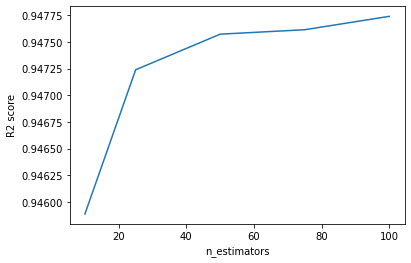

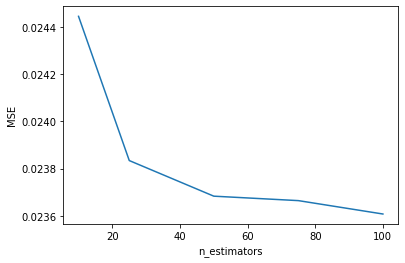

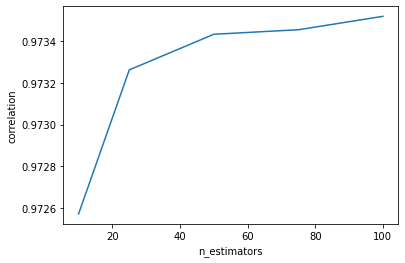

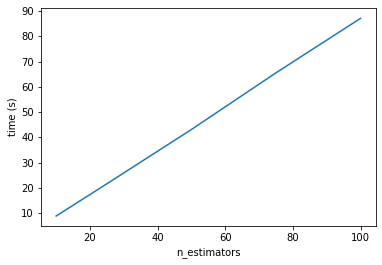

In [7]:
# plot
for i in range(len(measures)):
    fig = plt.figure()
    fig.patch.set_facecolor("white")

    plt.plot(hyperparam, measurelist[i])
    plt.xlabel(hpname)
    plt.ylabel(measures[i])


    if measures[i] == "R2 score":
        plt.savefig("Figures/hyperparam_RF_"+hpname+".png")

    plt.show()